In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, silhouette_score
from sklearn import preprocessing
from random import shuffle
import seaborn as sns

# 1. Random Forests Classification
## Loading the data

In [3]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Cleaning the data
As explained in [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we need to remove some bogus data. When there are less than 22 dyads for a specific referee, it means he or she hasn't met 22 players. Thus it means he or she didn't referee a match in one of the four leagues we study here. Thus we remove its entries.

In [4]:
ref_counts = df.refNum.value_counts()
valid_refs = ref_counts[ref_counts >= 22]
filtered = df[df.refNum.isin(valid_refs)].copy()

In [5]:
def count_unique_values(series):
    return series.value_counts().count()

old_nb_players = count_unique_values(df.playerShort)
new_nb_players = count_unique_values(filtered.playerShort)
delta = old_nb_players - new_nb_players

print('After filtering, we lose {} players, which represents {:.2f}% of the players.'.format(
        delta, delta/old_nb_players*100))
print('We still have N={} players in our dataset, which is enough.'.format(new_nb_players))

After filtering, we lose 42 players, which represents 2.05% of the players.
We still have N=2011 players in our dataset, which is enough.


In [6]:
old_nb_refs = count_unique_values(df.refNum)
delta = old_nb_refs - count_unique_values(filtered.refNum)

print('After filtering, we lose {} referees, which represents {:.2f}% of the referees.'.format(
        delta, delta/old_nb_refs*100))

After filtering, we lose 2830 referees, which represents 89.93% of the referees.


## Building the features
Since we're interested in predicting the skin color of a player, we'll group the data by player. First we can check that the `playerShort` field uniquely determines a player since there are no duplicates when we index by `playerShort` and `refNum` (i.e. a player-referee dyad).

In [7]:
filtered.set_index(['playerShort', 'refNum']).index.is_unique

True

In [8]:
filtered.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

We want to group the entries by player. Therefore we need to find a way to aggregate the data in a meaningful way to create good features. Let's have a look at the data we have and specify what we want to do with each column:
* __player__: we could use the first and/or last name of a player as a feature. Adding it as a feature using dummy variables would add too many dimensions. Processing it in a more complicated would be too complicated for this homework so we ignore it for now.
* __club__, __leagueCountry__: we encode these as a categorical feature using dummy variables
* __birthday__: we drop it since it should be independent of the skin color
* __height__, __weight__: we keep them as is since due to genetics skin color and height/weight could be correlated
* __position__: we encode it as a categorical feature
* __games__, __victories__, __ties__, __defeats__, __goals__: we sum these for each player
* __yellowCards__, __yellowReds__, __redCards__: likewise
* __photoID__: just a file name, not useful
* __rater1__, __rater2__: we replace these with a new feature which is the mean of the two
* __refNum__, __refCountry__, __Alpha_3__: we drop them since it's not related to the player and is redundant with the IAT and exp scores which are already related to the referee's country
* __meanIAT__, __meanExp__: we average them so that we know, on average, how biased were the referees the player met
* __seIAT__, __seExp__: we won't use them, they could be useful to estimate the accuracy of the IAT and Exp scores though
* __nIAT__, __nExp__: we drop them, anyway the standard error of the mean already take them (the number of samples used to computer meanIAT and meanExp) into account

First, we compute the average skin color rating of each player. We can also remove the players for which we don't have a rating of their skin color since we miss the label to add them to the dataset.

In [9]:
filtered['skinColor'] = (filtered.rater1 + filtered.rater2) / 2
filtered.dropna(subset=['rater1', 'rater2'], inplace=True)

print('We now have N={} players.'.format(count_unique_values(filtered.playerShort)))

We now have N=1572 players.


Do we want to drop the samples for which we miss some data or do we want to fill the missing data? As seen in the cell below, we only lose 159 players if we use `dropna()`, this is reasonable and should not impact our learning too much. Thus we drop these rows.

In [10]:
count_unique_values(filtered.playerShort) - count_unique_values(filtered.dropna().playerShort)

159

In [11]:
filtered.dropna(inplace=True)

As seen in the cells below. Encoding the league using dummy variables will create 4 features. This is not a problem. Likewise for the position of the player (12 distinct values). However, there are 91 different clubs in our dataset so encoding the club as dummy variables would create a large number of feature. We need to keep this in mind and see whether it's impacting negatively our classifier.

In [14]:
count_unique_values(filtered.leagueCountry)

4

In [15]:
count_unique_values(filtered.position)

12

In [16]:
count_unique_values(filtered.club)

91

We now group by and aggregate the data by player. We also encode the categorical features as dummy variables. Finally, we create two dataframes, X which is our set of samples and y which are the corresponding labels. We still need to discretize the y labels into multiple classes (skin tones). We'll do it later, let's first analyze a bit our dataset.

In [17]:
# Keys are the columns we want to keep and values are the aggregate function we want to use when calling groupby()
columns_to_keep = {'leagueCountry': 'first', 'height': 'first', 'weight': 'first',
                   'position': 'first', 'games': 'sum', 'victories': 'sum', 'ties': 'sum', 'defeats': 'sum',
                   'goals': 'sum', 'yellowCards': 'sum', 'yellowReds': 'sum', 'redCards': 'sum', 'skinColor': 'first',
                   'meanIAT': 'mean', 'meanExp': 'mean'}

# keep only the columns we want then groupby and aggregate per player
data = filtered[list(columns_to_keep.keys()) + ['playerShort']]
data = data.groupby('playerShort').agg(columns_to_keep)
# transform the categorical columns into dummy variables over multiple columns
data = pd.get_dummies(data, columns=['leagueCountry', 'position'])

y = data.skinColor # our labels
X = data.drop('skinColor', axis=1) # we need to remove the labels from the data

## Analyzing our freshly created dataset
Do we need to normalize numerical features? For a random forests classifier the answer is no. By default, Scikit-Learn uses the Gini impurity function as a criterion for the best split at each level of a tree. Any monotonic pre-processing of the features won't have any effect on the splits of the tree. See [this quora topic](https://www.quora.com/Should-inputs-to-random-forests-be-normalized) and [this page](http://jordiinglada.net/wp/2015/04/22/should-we-always-normalize-image-features-before-classification/) for more details.

As seen below, we have $N=1413$ samples and $D=28$ features.

In [18]:
X.shape

(1413, 28)

Our features are the following:

In [19]:
X.columns

Index(['weight', 'ties', 'victories', 'yellowReds', 'yellowCards', 'goals',
       'redCards', 'defeats', 'meanExp', 'meanIAT', 'games', 'height',
       'leagueCountry_England', 'leagueCountry_France',
       'leagueCountry_Germany', 'leagueCountry_Spain',
       'position_Attacking Midfielder', 'position_Center Back',
       'position_Center Forward', 'position_Center Midfielder',
       'position_Defensive Midfielder', 'position_Goalkeeper',
       'position_Left Fullback', 'position_Left Midfielder',
       'position_Left Winger', 'position_Right Fullback',
       'position_Right Midfielder', 'position_Right Winger'],
      dtype='object')

**We have a class imbalance issue!** If we discretize our skin color into 2 classes, we can see that 77% of the players are white people. Even with 5 classes, two of them contain most of the samples. We'll have to be aware of this issue when splitting our dataset and also while training and evaluating our model.

There are 76.86% of white people in the dataset


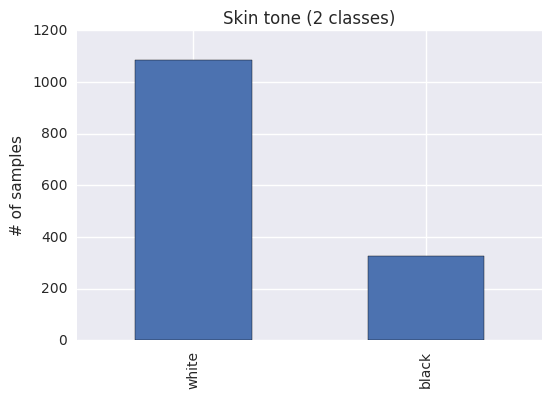

In [20]:
sns.set_style('darkgrid')
classes = pd.cut(y, bins=2, right=False, labels=['white', 'black'])
ratio = (classes == 'white').sum() / classes.count()
print('There are {:.2f}% of white people in the dataset'.format(ratio*100))
classes.value_counts().sort_index().plot(kind='bar', title='Skin tone (2 classes)')
plt.ylabel('# of samples')
plt.show()

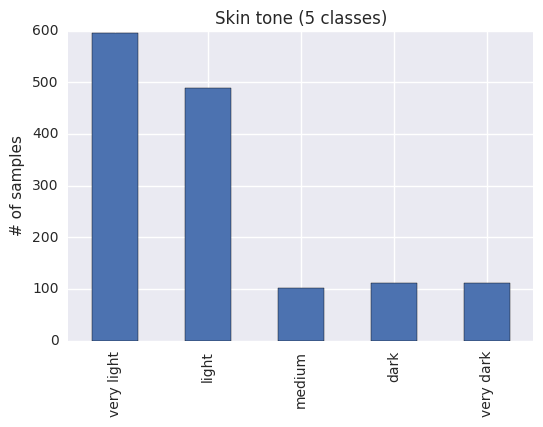

In [21]:
classes = pd.cut(y, bins=5, right=False, labels=['very light', 'light', 'medium', 'dark', 'very dark'])
classes.value_counts().sort_index().plot(kind='bar', title='Skin tone (5 classes)')
plt.ylabel('# of samples')
plt.show()

## Fitting the model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

First, we still need to discretize our labels vector $y$. To simplify the model, since the skin color is rated on a five-level scale and since we average the rating of two people anyway, we will create a binary classifier (black or white skin color).

Players with a skin color rating between 0 and 0.5 are labelled as white. Players with a skin color rating between 0.5 and 1.0 are labelled as black. To try to compensate for the class imbalance, players with a skin rating of 0.5 are classified as black.

From now on $y=0$ denotes players with light skin tone and $y=1$ players with dark skin tone.

In [24]:
y = pd.cut(y, bins=2, right=False, labels=np.arange(2)) # 0 is light, 1 is dark

### Dummy classifier
Due to the class imbalance problem, a classifier which predicts 0 (white) for all players will still have a good accuracy. This can be seen with the following dummy classifier. Indeed, since ~76% of the players are white, always predicting 0 already gives us a precision of 76% with an accuracy scoring function!

Thus, we'll need to be careful when choosing the scoring function to use. We'll also need to make sure that our classifier doesn't always predict 0, for instance using a confusion matrix.

In [25]:
clf = DummyClassifier('constant', constant=0)
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
print('Accuracy score: {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))

Accuracy score: 0.77 +/- 0.00


We can verify that indeed 76% of the samples in the training set have label 0

In [26]:
np.sum(y == 0) / len(y)

0.76857749469214443

As seen on the confusion matrix below, the predicted label is always 0.

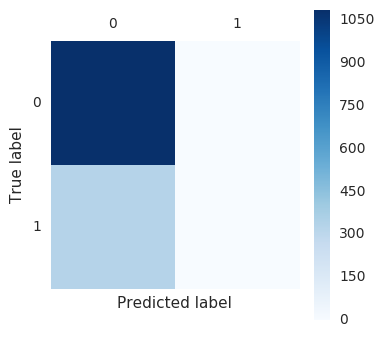

In [28]:
from utils import plot_confusion_matrix
clf.fit(X, y)
plot_confusion_matrix(y, clf.predict(X))

### Random forests classifier

Let's see the score achieved by the random forest classifier of Scikit-Learn with the default parameters. As we've seen above, the accuracy score is misleading because of the class imbalance. Thus, we'll use the F1 score and the BER (balanced error rate) for the rest of this notebook.

The BER takes the number of samples per class into account and thus is less sensitive to class imbalance. For binary classification, the formula is:

$$BER = \frac{1}{2} \left( \frac{FN}{TP+FN} + \frac{FP}{FP+TN} \right)$$

TP are true positives, FN are false negatives, FP are false positives and TN are true negatives.

In [29]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=10, scoring='f1')
print('F1 score: {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))

F1 score: 0.30 +/- 0.05


In [31]:
from utils import ber
ber_scorer = make_scorer(ber, greater_is_better=False, classes=[0,1])
scores = cross_val_score(rf, X, y, cv=10, scoring=ber_scorer)
print('BER: {:.2f} +/- {:.2f}'.format(-np.mean(scores), np.std(scores)))

BER: 0.56 +/- 0.03


The results are disappointing. Note that lower is better for the BER (it's an error) while greater is better for the F1 score. Let's try to see what's happening here and plot the learning curve to see if our model has high bias or high variance.

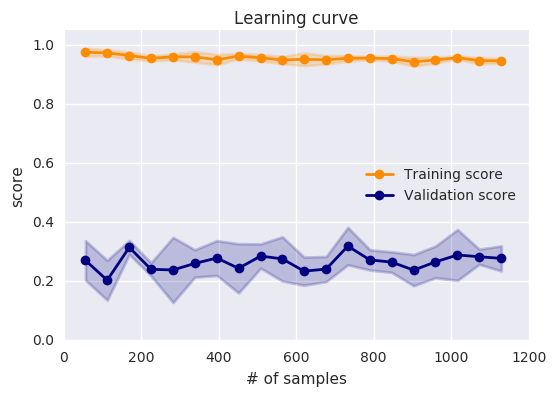

In [32]:
from utils import plot_learning_curve
plot_learning_curve(rf, X, y, np.linspace(.05, 1.0, 20), scorer='f1', legend_loc='center right')

We notice that there is a huge difference between the training and the validation score. Moreover the training score is really high from the beginning and the validation score barely increases. This seems to indicate that we have high variance and that our model is overfitting. Now let's try to see which parameters could help us mitigate overfitting.

#### Analyzing parameters
We can see that our model overfits really quickly as the maximum depth increases. With a low `max_depth` parameter our model underfits, this can be seen in the left of the plot where both the training and validation score are low. Then the training score gets really high while the test score doesn't increase anymore, this means we're overfitting.

The following curves were obtaining using cross-validation. The plain line are the mean scores, the filled areas are the standard deviations of the scores. 

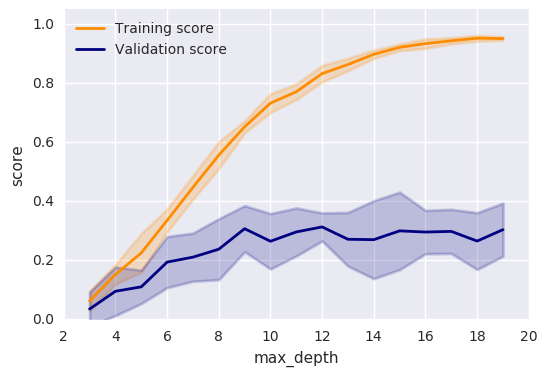

In [33]:
from utils import plot_validation_curve
import warnings

# we temporarily ignore warnings about ill-conditionned f1 score (the f1 score is undefined when there are no 1s)
# a very low max_depth make the classifier predict only 0
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_validation_curve(rf, X, y, 'max_depth', np.arange(3,20), scorer='f1', cv=10)

A value of 12 for `max_depth` seems to be a sensible value to avoid overfitting.

In the plots below, we can see that neither the `n_estimators` nor the `max_features` parameters seem to help improving our model.

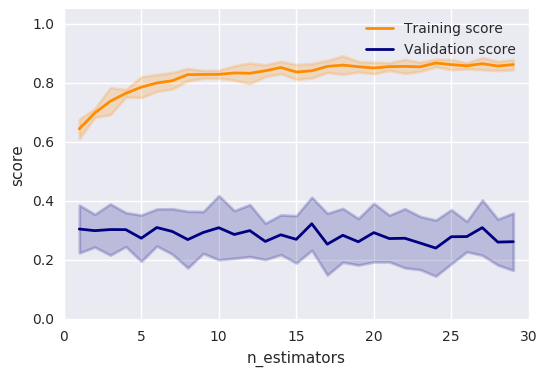

In [34]:
plot_validation_curve(RandomForestClassifier(max_depth=12), X, y, 'n_estimators', np.arange(1,30), 'f1', cv=10)

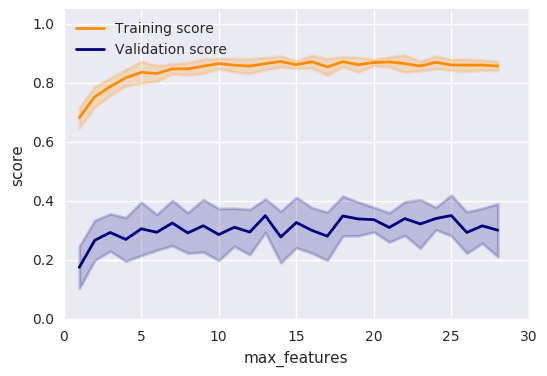

In [35]:
plot_validation_curve(RandomForestClassifier(max_depth=12), X, y, 'max_features', np.arange(1,29), 'f1', cv=10)

#### Feature importances
Let's have a look at the features that are considered important by our classifier. The following is the list of features sorted by decreasing order of importance.

We expect the meanIAT and meanExp to be important since they can indicate the player's skin color when associated with the number of yellow and red cards he received (under the assumption that a biased referee would be stricter). However the importance of redCards and yellowReds is quite low. Also, the number of games, defeats, ties and victories seem to be important but should not indicate the skin color.

In the second cell, we drop the redCards, yellowCards and yellowReds features. We observe that the the meanIAT and meanExp are still the most important feature. However they're only related to the referee and without any information about the cards the player received, they should not indicate the skin color.

These observations and the fact that our test score is low seems to indicate that there is no pattern in the data that our classifier could use to classify people by skin color.

In [36]:
clf = RandomForestClassifier(max_depth=12)
clf.fit(X, y)
sorted(zip(X.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)

[('meanIAT', 0.14083752339738492),
 ('meanExp', 0.11247714675976783),
 ('games', 0.086633537239025782),
 ('height', 0.071684400129283316),
 ('weight', 0.071571946683322424),
 ('victories', 0.070926379720039998),
 ('defeats', 0.064405432207797347),
 ('ties', 0.062127323936461219),
 ('yellowCards', 0.049112108485550483),
 ('goals', 0.048290605985790894),
 ('leagueCountry_France', 0.047270795508856454),
 ('leagueCountry_Germany', 0.021450851713123515),
 ('position_Right Winger', 0.016418730165242534),
 ('leagueCountry_England', 0.015322844023346669),
 ('position_Center Back', 0.013363547152194876),
 ('position_Goalkeeper', 0.01271642563324663),
 ('position_Center Forward', 0.01247484719008533),
 ('redCards', 0.012199055455883998),
 ('position_Left Winger', 0.011288953268210448),
 ('yellowReds', 0.010105517962966441),
 ('position_Defensive Midfielder', 0.0092202987055902755),
 ('position_Attacking Midfielder', 0.0085209652590585681),
 ('leagueCountry_Spain', 0.00827143887194157),
 ('positi

In [37]:
alt_X = X.drop(['redCards', 'yellowReds', 'yellowCards'], axis=1)
clf = RandomForestClassifier(max_depth=12)
clf.fit(alt_X, y)
sorted(zip(alt_X.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)

[('meanIAT', 0.13429359223582163),
 ('meanExp', 0.1166301863757859),
 ('games', 0.10514148469218747),
 ('weight', 0.086164989735916617),
 ('defeats', 0.078918826911944323),
 ('ties', 0.071176146853723116),
 ('height', 0.068387870757298574),
 ('victories', 0.067252730597204782),
 ('leagueCountry_France', 0.056088942836869736),
 ('goals', 0.051462348188949125),
 ('leagueCountry_Germany', 0.02694201791652328),
 ('position_Goalkeeper', 0.019770417139047647),
 ('leagueCountry_England', 0.017571303749904645),
 ('position_Center Forward', 0.012742938507264759),
 ('position_Defensive Midfielder', 0.010895432487049661),
 ('position_Center Back', 0.010338762526498962),
 ('position_Left Winger', 0.009626776829522659),
 ('leagueCountry_Spain', 0.0093690463402958842),
 ('position_Right Winger', 0.0091984850722821223),
 ('position_Attacking Midfielder', 0.008493848938418095),
 ('position_Left Fullback', 0.008191568596795859),
 ('position_Right Midfielder', 0.0071160090695068373),
 ('position_Right F

In [38]:
rf = RandomForestClassifier(max_depth=12)
scores = cross_val_score(rf, alt_X, y, cv=10, scoring='f1')
print('F1 score: {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))

F1 score: 0.30 +/- 0.06


#### Bonus
We noticed that the parameter affecting the overfitting the most is the maximum depth of the trees. If it is small, we don't overfit but we have high bias. This can be seen on the first of the following learning curves. The validation score and the training score are close but both are very low. When the maximum depth is high, as can be seen on the second plot, the training error is high and the validation error stays low, we're overfitting.

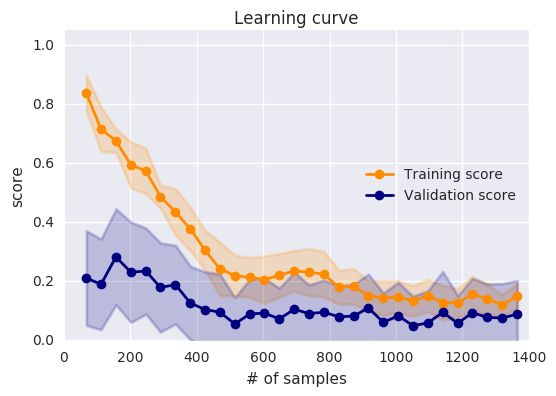

In [39]:
# We ignore the warnings about the ill-conditionned f1 score which happens with a low number of samples
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(RandomForestClassifier(max_depth=4), X, y, np.linspace(.05, 1.0, 30),
                        cv=30, scorer='f1', legend_loc='center right')

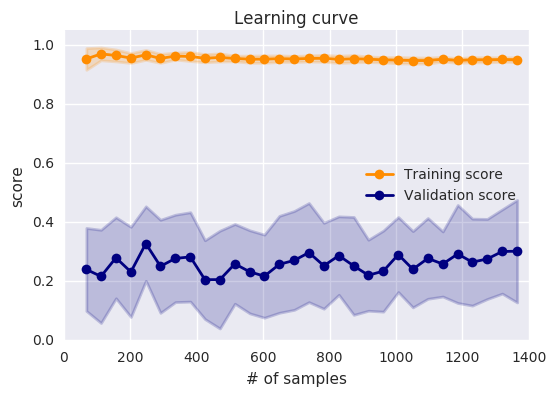

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_learning_curve(RandomForestClassifier(max_depth=50), X, y, np.linspace(.05, 1.0, 30),
                        cv=30, scorer='f1', legend_loc='center right')

# 2. Clustering

_Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results._

As asked, the data will be grouped by player and the columns containing information about the referee will be aggregated. First, let's get a fresh copy of the data and drop NaN values.

In [34]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.dropna(inplace=True)

Now, as seen in exercise 1, the classes are completely imbalanced. Because of this, basic scoring functions such as F1 cannot be used, as they would output incorrect accuracy. As an example, we can group the data by player, use a binary representation of the skin color (black & white) and check what accuracy we can acheive by predicting that every player is white.

In [35]:
# Compute the skin tone
# If skinTone <= 0.5 --> 0 (white)
# If skinTone > 0.5 --> 1 (black)
skinTone = (df.rater1 + df.rater2)/2
df['skinTone'] = round(skinTone)

truth = df.groupby('playerShort').first()['skinTone']

1 - f1_score(truth, np.ones(len(truth)))

0.724179829890644

We reached 72% precision without even training any algorithm ! Of course, this scoring function can't be used. Let's try something else.

In [36]:
def ber(truth, predicted, classes):
    errors = 0
    lengths = [len(truth[truth == c]) for c in classes]
    n = len(truth)
    
    for c in classes:
        classError = 0  # Use a second variable to avoid float precision error when doing += 1/n
        for i in range(n):
            if predicted[i] != truth[i] and c == truth[i]:
                classError += 1
        errors += classError/lengths[c]
            
    return errors/len(classes)

# Make this a scorer function
ber_scorer = make_scorer(ber, greater_is_better=False)

In [37]:
1 - ber(truth, np.ones(len(truth)), [0, 1])

0.5

Ok this is better ! Using the Balanced Error Rate (http://icapeople.epfl.ch/mekhan/pcml15/project-2/objectDetection.html) we know obtain a precision of 50% when predicting that everybody is black. Now let's move to the problem itself. Group the data by player and average referee-related columns.

In [38]:
# Aggregate referees variables after grouping by players
tosum = ['playerShort', 'yellowCards', 'yellowReds', 'redCards', 'games', 'ties', 'goals']
tocollect = ['playerShort']
tomean = ['playerShort', 'meanIAT', 'meanExp']
tomeanstd = ['playerShort', 'seIAT', 'seExp']

group1 = df[tosum].groupby('playerShort').sum()
group2 = df[tocollect].groupby('playerShort').first()
group3 = df[tomean].groupby('playerShort').mean()
group4 = df[tomeanstd].groupby('playerShort').agg(lambda x: np.sqrt(np.mean(x**2)/len(x)))

agg = pd.concat([group1, group2, group3, group4], axis=1)

agg.head(5)

,yellowCards,yellowReds,redCards,games,ties,goals,meanIAT,meanExp,seIAT,seExp
playerShort,,,,,,,,,,
aaron-hughes,19,0,0,654,179,9,0.346459,0.494575,0.000257,0.002137
aaron-hunt,42,0,1,336,73,62,0.348818,0.449220,0.000055,0.000252
aaron-lennon,11,0,0,412,97,31,0.345893,0.491482,0.000126,0.000887
aaron-ramsey,31,0,1,260,42,39,0.346821,0.514693,0.002757,0.010251
abdelhamid-el-kaoutari,8,4,2,124,40,1,0.331600,0.335587,0.001037,0.003851


You can see that we keep some player-related variables such has yellowCards, redCards, etc. This is because this also somewhat related to the referees, even if it is averaged, and we don't want to loose too much data. It if it useless, the feature engineering algorithm will remove them anyway.

Let's now define a few other functions that we will use with KMeans.

In [39]:
# Change the order of the features
def shuffle_features(X):
    index = X.columns.values.tolist()
    shuffle(index)
    return X[index]

In [40]:
# Works with tuples (score, silhouette, fit, features)
def compare_and_swap(best, current):
    if current[0] > best[0]:
        print("=== Current Best ===")
        print("Best accuracy: " + str(current[0]))
        print("Silhouette score: " + str(current[1]))
        print("Features: " + str(current[3]))
        print("====================\n")
        return current
    else:
        return best

In [41]:
# Scale the between 0 and 1
def scale(X):
    columns = X.columns
    index = X.index
    X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(agg))
    X.columns = columns
    X.index = index
    return X

Redefine the skin tone, but this time, round half up. This give a more balanced distribution. It is still very imbalanced.

In [42]:
df['skinTone'] = (df.rater1 + df.rater2)/2
skinTone = df.groupby('playerShort').first()['skinTone']
skinTone[skinTone >= 0.5] = 1
skinTone[skinTone < 0.5] = 0

Compute the clusters centers using KMeans. The algorithm is run multiple times with one feature removed at each iteration. When no feature remains, the algorithm is restarted with all the feature in randomized order.

In [43]:
agg = scale(agg)
score = (0, 0, None, [])  # (accuracy, silhouette score, kmeans fit, selected features)

for i in range(50):
    data = shuffle_features(agg)
    
    while (len(data.columns) > 1):
        data = data[data.columns[:-1]]
        
        kmeans = KMeans(2)
        fit = kmeans.fit(data)

        silhouette = silhouette_score(data, fit.labels_)
        newScore = (1 - ber(skinTone, fit.labels_, [0, 1]), silhouette, fit, data.columns.values)
        score = compare_and_swap(score, newScore)

=== Current Best ===
Best accuracy: 0.5009182736455464
Silhouette score: 0.335360200823
Features: ['ties' 'yellowCards' 'games' 'seIAT' 'seExp' 'redCards' 'yellowReds'
 'meanExp' 'meanIAT']

=== Current Best ===
Best accuracy: 0.51455463728191
Silhouette score: 0.469744547112
Features: ['ties' 'yellowCards' 'games' 'seIAT']

=== Current Best ===
Best accuracy: 0.5212580348943985
Silhouette score: 0.391638975971
Features: ['games' 'yellowCards' 'meanIAT']

=== Current Best ===
Best accuracy: 0.5847566574839302
Silhouette score: 0.343273517166
Features: ['seExp' 'meanIAT' 'goals' 'seIAT']

=== Current Best ===
Best accuracy: 0.585307621671258
Silhouette score: 0.506099949822
Features: ['seExp' 'meanIAT']

=== Current Best ===
Best accuracy: 0.5904040404040404
Silhouette score: 0.834251829451
Features: ['seExp']



The best accuracy obtained is around 60%, which is very low. The cell below contains the best fit we had after a few runs.

In [44]:
centers = np.array([[0.02057524], [0.20463645]])
data = agg['seExp']

fit = KMeans(2, init=centers, n_init=1).fit(data.reshape(-1, 1))

silhouette = silhouette_score(data.reshape(-1, 1), fit.labels_)
accuracy = 1 - ber(skinTone, fit.labels_, [0, 1])

print("Silhouette: {}".format(silhouette))
print("Accuracy: {}".format(accuracy))

Silhouette: 0.8342518294512679
Accuracy: 0.5904040404040404


We can conclude that there is now way to correctly clusterize the players by skin color using referees features. Let's plot the confusion matrix.

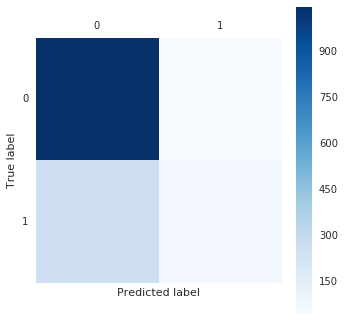

In [45]:
sns.set_style('dark')
cm = confusion_matrix(skinTone, score[2].labels_)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As expected, even if the BER accuracy is 60%, a lot of points are misclassified. Also, the precision comes mostly from white people correctly classified as white people, which already push the accuracy to 50% even with BER.